In [80]:
# ============================================================
# 1. Load Multimodal Dataset
# ============================================================
import pandas as pd
import numpy as np

df = pd.read_csv("LUAD_multimodal_dataset.csv")
print("Loaded:", df.shape)
print("Survival label values:", df["survival_label"].unique())

df.head()


Loaded: (40, 227)
Survival label values: ['Long' 'Short']


,PatientID,survival_label,Longest.Diameter..mm.,Short.Axis...Longest.Diameter..mm..,Short.Axis..mm.,Mean..HU.,StdDev..HU.,Volume..cm..,X5a_3D_MacSpic_NumberOf,X8a_3D_Is_Attached_To_Pleural_Wall,...,X3D.Wavelet.decomposition...P1.L2.C5.Layer.1,X3D.Wavelet.decomposition...P1.L2.C6.Layer.1,X3D.Wavelet.decomposition...P1.L2.C7.Layer.1,X3D.Wavelet.decomposition...P1.L2.C8.Layer.1,Convexity_Mean,Conv_Area_Perim,IsAttached,Std_Conv,Report,ImagePath
0,R0004,Long,45.50,1520.73,33.42,-20.13,136.80,33.06,0,0,...,25833.098760,8449.116111,737.184747,6172.425054,0.863500,0.642984,0.863500,0.097923,"CT scan shows left hilum 45.5 mm mass, Stage I...",C:\Users\sohel\Downloads\Ai_health\LUAD_CT_SUR...
1,R0013,Long,41.82,617.67,14.77,-9.56,119.63,14.78,0,1,...,15237.079170,4561.750068,613.539088,3699.644891,0.845099,0.866819,0.807820,0.027609,"CT scan shows right lower lobe 41.82 mm mass, ...",C:\Users\sohel\Downloads\Ai_health\LUAD_CT_SUR...
2,R0017,Long,18.95,240.46,12.69,-73.58,151.36,1.76,0,1,...,1585.785644,2164.498445,59.819492,491.460387,0.931435,0.918455,0.931435,0.013920,Stage IV left hilum tumor measuring 18.95 mm. ...,C:\Users\sohel\Downloads\Ai_health\LUAD_CT_SUR...
3,R0018,Short,35.04,1086.57,31.01,28.45,93.49,16.85,0,1,...,12430.672920,3005.110061,400.538246,3257.483750,0.917999,0.897987,0.917999,0.025730,left hilum lesion (35.04 mm) consistent with S...,C:\Users\sohel\Downloads\Ai_health\LUAD_CT_SUR...
4,R0019,Short,31.87,613.64,19.25,-30.00,146.40,10.97,0,1,...,8299.075649,2753.117372,89.089983,381.985943,0.931737,0.946039,0.860215,0.039337,Stage IV right lower lobe tumor measuring 31.8...,C:\Users\sohel\Downloads\Ai_health\LUAD_CT_SUR...


In [81]:
# ============================================================
# 2. Clean Labels (long=1, short=0)
# ============================================================
df["survival_label"] = df["survival_label"].astype(str).str.lower()
y = (df["survival_label"] == "long").astype(int).to_numpy()

print("Binary y labels:", np.unique(y))


Binary y labels: [0 1]


In [82]:
# ============================================================
# 3. Select Numeric Radiomics Features Only
# ============================================================
drop_cols = ["PatientID", "survival_label", "Report", "ImagePath", "SegPath"]

# all numeric radiomics features
radiomics_cols = [
    c for c in df.columns
    if c not in drop_cols and df[c].dtype != "object"
]

print("Numeric radiomics count:", len(radiomics_cols))

# convert to numeric
X_rad = df[radiomics_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values


Numeric radiomics count: 223


In [83]:
# ============================================================
# 4. Load Precomputed BERT Text Embeddings
# ============================================================
emb = np.load("text_embeddings.npy")
print("Text embedding shape:", emb.shape)   # (40, 768)

# Safety check
assert emb.shape[0] == df.shape[0], "Embedding rows do not match dataset rows!"

# ============================================================
# 5. Select Numeric Radiomics Features
# ============================================================
drop_cols = ["PatientID", "survival_label", "Report", "ImagePath", "SegPath"]

radiomics_cols = [
    c for c in df.columns
    if c not in drop_cols and df[c].dtype != "object"
]

print("Radiomics features:", len(radiomics_cols))

# Convert to numeric
X_rad = df[radiomics_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values

# ============================================================
# 6. Scale Radiomics and Text Separately
# ============================================================
from sklearn.preprocessing import StandardScaler

scaler_rad = StandardScaler()
X_rad_scaled = scaler_rad.fit_transform(X_rad)

scaler_txt = StandardScaler()
emb_scaled = scaler_txt.fit_transform(emb)

# ============================================================
# 7. Combine into Final Multimodal Matrix
# ============================================================
X = np.hstack([X_rad_scaled, emb_scaled])

print("Final X shape:", X.shape)
assert X.shape[0] == df.shape[0], "Row mismatch after combining!"


Text embedding shape: (40, 768)
Radiomics features: 223
Final X shape: (40, 991)


In [84]:
# ============================================================
# 6. Train/Validation Split (with stratification)
# ============================================================
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Track indices for later prediction merge
indices = np.arange(len(X))

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X, y, indices,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32).to(device)


In [85]:
class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1)  # logits
        )

    def forward(self, x):
        return self.model(x)


In [86]:
epochs = 50

for epoch in range(epochs):
    model.train()

    preds = model(X_train)
    loss = criterion(preds, y_train)

    optimizer.zero_grad()
    loss.backward()

    # 🛑 GRADIENT CLIPPING
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val)

    print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")


Epoch 000 | Train Loss: 0.6655 | Val Loss: 0.9367
Epoch 001 | Train Loss: 0.6487 | Val Loss: 0.9288
Epoch 002 | Train Loss: 0.6536 | Val Loss: 0.9190
Epoch 003 | Train Loss: 0.6138 | Val Loss: 0.9090
Epoch 004 | Train Loss: 0.6000 | Val Loss: 0.8986
Epoch 005 | Train Loss: 0.5844 | Val Loss: 0.8887
Epoch 006 | Train Loss: 0.5769 | Val Loss: 0.8785
Epoch 007 | Train Loss: 0.5729 | Val Loss: 0.8679
Epoch 008 | Train Loss: 0.5290 | Val Loss: 0.8588
Epoch 009 | Train Loss: 0.5275 | Val Loss: 0.8515
Epoch 010 | Train Loss: 0.5048 | Val Loss: 0.8466
Epoch 011 | Train Loss: 0.4995 | Val Loss: 0.8436
Epoch 012 | Train Loss: 0.4845 | Val Loss: 0.8423
Epoch 013 | Train Loss: 0.4702 | Val Loss: 0.8432
Epoch 014 | Train Loss: 0.4718 | Val Loss: 0.8453
Epoch 015 | Train Loss: 0.4624 | Val Loss: 0.8489
Epoch 016 | Train Loss: 0.4421 | Val Loss: 0.8535
Epoch 017 | Train Loss: 0.4378 | Val Loss: 0.8588
Epoch 018 | Train Loss: 0.4135 | Val Loss: 0.8649
Epoch 019 | Train Loss: 0.4240 | Val Loss: 0.8707


In [87]:
# ============================================================
# 9. Predict Validation Probabilities
# ============================================================
model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(X_val)).detach().cpu().numpy().flatten()

df_val = df.iloc[idx_val].copy()
df_val["Predicted_Survival_Prob"] = probs

df_val.to_csv("multimodal_predictions.csv", index=False)
print("Saved → multimodal_predictions.csv")


Saved → multimodal_predictions.csv


In [88]:
# ============================================================
# 10. Assign Risk Groups (Median Split)
# ============================================================
median_prob = df_val["Predicted_Survival_Prob"].median()

df_val["RiskGroup"] = np.where(
    df_val["Predicted_Survival_Prob"] >= median_prob,
    "High Risk",
    "Low Risk"
)

print(df_val["RiskGroup"].value_counts())


RiskGroup
High Risk    5
Low Risk     5
Name: count, dtype: int64


In [89]:
# ============================================================
# 11. Simulate Survival Times for KM Curve (Demo Only)
# ============================================================
np.random.seed(42)

df_val["SurvivalTime"] = np.where(
    df_val["survival_label"] == "long",
    np.random.normal(900, 120, df_val.shape[0]),
    np.random.normal(350, 80,  df_val.shape[0])
)

# Fix invalid values
df_val["SurvivalTime"] = df_val["SurvivalTime"].clip(lower=1)
df_val["Event"] = 1


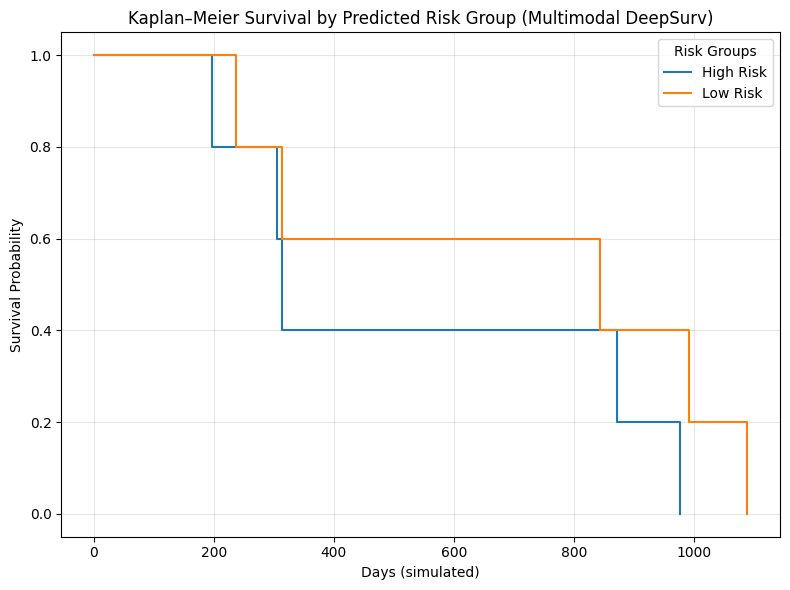

Saved → KM_multimodal_risk_groups.png


In [90]:
# ============================================================
# 12. Kaplan–Meier Survival Curves
# ============================================================
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for group, subdf in df_val.groupby("RiskGroup"):
    kmf.fit(
        durations=subdf["SurvivalTime"],
        event_observed=subdf["Event"],
        label=group
    )
    kmf.plot(ci_show=False)

plt.title("Kaplan–Meier Survival by Predicted Risk Group (Multimodal DeepSurv)")
plt.xlabel("Days (simulated)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.legend(title="Risk Groups")
plt.tight_layout()

plt.savefig("KM_multimodal_risk_groups.png", dpi=300)
plt.show()

print("Saved → KM_multimodal_risk_groups.png")


In [91]:
# ============================================================
# 13. Log-Rank Test Between Risk Groups
# ============================================================
from lifelines.statistics import logrank_test

high = df_val[df_val["RiskGroup"] == "High Risk"]
low  = df_val[df_val["RiskGroup"] == "Low Risk"]

results = logrank_test(
    high["SurvivalTime"], low["SurvivalTime"],
    event_observed_A=high["Event"],
    event_observed_B=low["Event"]
)

print("Log-rank p-value:", results.p_value)


Log-rank p-value: 0.3187725590645609
